# Get the Rating Matrix

In [1]:
# ! pip install apyori

In [2]:
# !pip install mlxtend  


In [3]:
# !pip install efficient-apriori

In [4]:
import pandas as pd 
data_with_3 = pd.read_csv("../datasets/ratings_with_3_combinations_reduced.csv")[["rating", "bill"]]

data_with_3.head()

,rating,bill
0,1,"(745321, 666652)"
1,12,"(772494, 754574)"
2,1,"(772494, 745328)"
3,11,"(772494, 749358)"
4,1,"(772494, 745310)"


In [5]:
data_3_greater_1 = data_with_3[data_with_3.rating > 1] 

data_3_greater_1.head() 

,rating,bill
1,12,"(772494, 754574)"
3,11,"(772494, 749358)"
5,6,"(754574, 745328)"
6,23,"(754574, 749358)"
7,7,"(754574, 745310)"


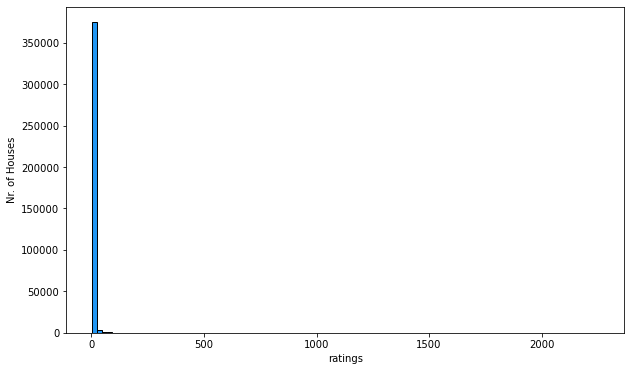

In [6]:
# If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.hist(data_3_greater_1['rating'], bins=100, ec='black', color='#2196f3')
plt.xlabel('ratings')
plt.ylabel('Nr. of Houses')
plt.show()

In [7]:
max(data_3_greater_1.rating),  min(data_3_greater_1.rating)

(2255, 2)

c:\Users\melih.kacaman\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

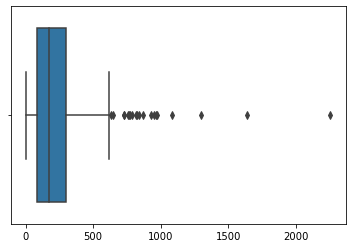

In [8]:
import seaborn as sns
sns.boxplot(data_3_greater_1['rating'].unique())

In [9]:
import numpy as np
data_3_greater_1_log = data_3_greater_1.copy() 
data_3_greater_1_log["rating"] = np.log(data_3_greater_1.rating) 

data_3_greater_1_log.head() 

,rating,bill
1,2.484907,"(772494, 754574)"
3,2.397895,"(772494, 749358)"
5,1.791759,"(754574, 745328)"
6,3.135494,"(754574, 749358)"
7,1.945910,"(754574, 745310)"


In [10]:
max(data_3_greater_1_log.rating),  min(data_3_greater_1_log.rating)

(7.720905251936779, 0.6931471805599453)

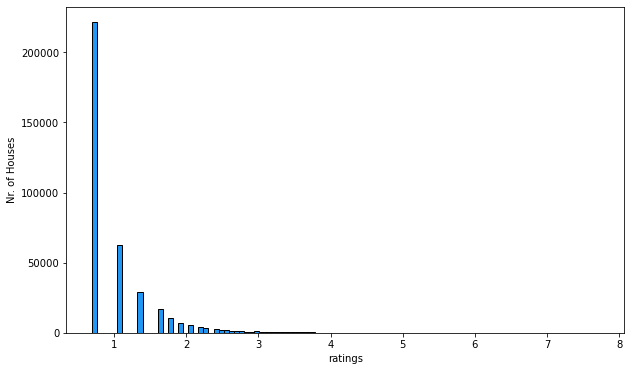

In [11]:
# If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.hist(data_3_greater_1_log['rating'], bins=100, ec='black', color='#2196f3')
plt.xlabel('ratings')
plt.ylabel('Nr. of Houses')
plt.show()

c:\Users\melih.kacaman\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

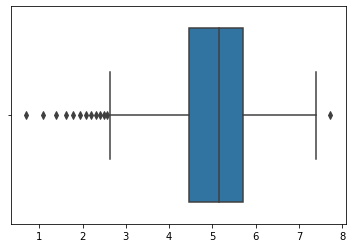

In [12]:
import seaborn as sns
sns.boxplot(data_3_greater_1_log['rating'].unique())

In [13]:
import numpy as np 
Q1 = np.percentile(data_3_greater_1_log['rating'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(data_3_greater_1_log['rating'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

print("data_3_greater_1_log has IQR:", IQR) 

data_3_greater_1_log has IQR: 0.6931471805599453


In [14]:
import pandas as pd
data_raw = pd.read_csv("../datasets/raw_data.csv") 

In [15]:
data_raw.head() 

,Unnamed: 0,optionId,bill
0,0,751839,1
1,1,751782,1
2,2,745321,1
3,3,666652,1
4,4,751873,2


In [16]:
transactions = [] 

bill = 1
option_bill = [] 

for index,row in data_raw.iterrows(): 
    if(row.bill == bill):
        option_bill.append(row.optionId)
    else:
        bill = row.bill 
        transactions.append(tuple(set(option_bill))) 
        option_bill.clear()
        option_bill.append(row.optionId)  


transactions[:3]

[(745321, 666652, 751782, 751839),
 (751873, 760125),
 (772494, 754574, 745328, 749358, 745310)]

# Model 1: Matrix Factorization Using Keras 

#### Data Prep for MF 

In [17]:
data_3_greater_1_log.head() 

,rating,bill
1,2.484907,"(772494, 754574)"
3,2.397895,"(772494, 749358)"
5,1.791759,"(754574, 745328)"
6,3.135494,"(754574, 749358)"
7,1.945910,"(754574, 745310)"


In [18]:
from ast import literal_eval

data_3_greater_1_log.bill = data_3_greater_1_log.bill.apply(literal_eval) 
data_3_greater_1_log.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380442 entries, 1 to 4492451
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rating  380442 non-null  float64
 1   bill    380442 non-null  object 
dtypes: float64(1), object(1)
memory usage: 8.7+ MB


In [19]:
type(data_3_greater_1_log.bill.iat[0])

tuple

In [20]:
statement = (772494, 754574, 749358) 
s_set = set(statement) 
tuple(s_set.difference([772494]))

(749358, 754574)

In [21]:
def split_bill(statement):
    return [
        (tuple(set(statement).difference([statement[0]])), statement[0]),
        (tuple(set(statement).difference([statement[1]])), statement[1]),
        (tuple(set(statement).difference([statement[2]])), statement[2])
    ]

In [22]:
data_3_greater_1_log["option_count"] = data_3_greater_1_log.bill.apply(lambda x: len(x))
data_3_greater_1_log.tail() 

,rating,bill,option_count
4490148,0.693147,"(774694, 767718, 767721)",3
4490843,0.693147,"(774590, 774319)",2
4490847,0.693147,"(774469, 774590, 774319)",3
4491087,0.693147,"(764896, 786771, 774571)",3
4492451,0.693147,"(748899, 748868, 752949)",3


In [23]:
sublist_by_2 = data_3_greater_1_log[data_3_greater_1_log.option_count == 2]

In [24]:
sublist_by_2_concat = pd.concat([
    sublist_by_2,
    pd.DataFrame(data_3_greater_1_log[data_3_greater_1_log.option_count == 2].bill.to_list(), columns=["LHS", "RHS"], index=sublist_by_2.index)
], axis=1)
sublist_by_2_concat.head()

,rating,bill,option_count,LHS,RHS
1,2.484907,"(772494, 754574)",2,772494,754574
3,2.397895,"(772494, 749358)",2,772494,749358
5,1.791759,"(754574, 745328)",2,754574,745328
6,3.135494,"(754574, 749358)",2,754574,749358
7,1.945910,"(754574, 745310)",2,754574,745310


In [25]:
sublist_by_3 = data_3_greater_1_log[data_3_greater_1_log.option_count == 3]
sublist_by_3.head() 

,rating,bill,option_count
12,0.693147,"(772494, 754574, 749358)",3
18,0.693147,"(754574, 745328, 745310)",3
34,1.098612,"(751649, 751591, 751532)",3
35,0.693147,"(751649, 751591, 751597)",3
36,0.693147,"(751649, 751595, 751532)",3


In [26]:
replicated_rows = pd.DataFrame(np.repeat(sublist_by_3.values, 3, axis=0), columns=sublist_by_3.columns)

sublists_by_3_reduced = []  
for item in sublist_by_3.bill.to_list():
    sublists_by_3_reduced += split_bill(item) 

sublists_by_3_reduced = pd.DataFrame(sublists_by_3_reduced, columns=["LHS", "RHS"])

sublist_by_3_concat = pd.concat([
    replicated_rows, 
    sublists_by_3_reduced
], axis=1)

sublist_by_3_concat.head() 

,rating,bill,option_count,LHS,RHS
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328


In [27]:
dataset_combined_MF = pd.concat([sublist_by_3_concat, sublist_by_2_concat], axis=0, ignore_index=True)
dataset_combined_MF.head()  

,rating,bill,option_count,LHS,RHS
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328


In [28]:
dataset_combined_MF.option_count.unique() 

array([3, 2], dtype=object)

In [29]:
sublist_by_2_concat["LHS_C"] = sublist_by_2_concat.LHS.astype('category').cat.codes.values
sublist_by_2_concat["RHS_C"] = sublist_by_2_concat.RHS.astype('category').cat.codes.values

sublist_by_2_concat.head() 

,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
1,2.484907,"(772494, 754574)",2,772494,754574,4116,3329
3,2.397895,"(772494, 749358)",2,772494,749358,4116,2675
5,1.791759,"(754574, 745328)",2,754574,745328,3303,2414
6,3.135494,"(754574, 749358)",2,754574,749358,3303,2675
7,1.945910,"(754574, 745310)",2,754574,745310,3303,2403


In [30]:
len(sublist_by_2_concat.RHS_C.unique()), len(sublist_by_2_concat.LHS_C.unique())

(4800, 4764)

## Building MF Model 

### Model: With 2's Combine 

In [31]:
from tensorflow import keras
from keras.optimizers import Adam 

n_rhs, n_lhs = len(sublist_by_2_concat.RHS_C.unique()), len(sublist_by_2_concat.LHS_C.unique())
n_latent_factors = 20
# input, embedding --> 
lhs_input = keras.layers.Input(shape=(1,), name="lhs-item") 
lhs_embedding = keras.layers.Embedding(n_lhs + 1, n_latent_factors, name="lhs-embeddings")(lhs_input) 
lhs_vec = keras.layers.Flatten(name="flatten-lhs")(lhs_embedding) 

rhs_input= keras.layers.Input(shape=(1,), name="rhs-item")
rhs_embedding = keras.layers.Embedding(n_rhs + 1, n_latent_factors, name="rhs-embeddings")(rhs_input) 
rhs_vec = keras.layers.Flatten(name="flatten-rhs")(rhs_embedding)

product = keras.layers.dot([lhs_vec, rhs_vec], axes=1, name="dot-product") 

model = keras.Model([lhs_input, rhs_input], product) 


In [32]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lhs-item (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 rhs-item (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 lhs-embeddings (Embedding)     (None, 1, 20)        95300       ['lhs-item[0][0]']               
                                                                                                  
 rhs-embeddings (Embedding)     (None, 1, 20)        96020       ['rhs-item[0][0]']               
                                                                                              

In [33]:
initial_weights = model.get_weights()

In [34]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(sublist_by_2_concat[["RHS_C", "LHS_C"]], sublist_by_2_concat.rating, test_size=0.10) 
X_train[:5], y_train[:5]

(         RHS_C  LHS_C
 2170298    541   2397
 3019857      1     17
 1292598   1780   1403
 2953717   3838   1230
 2703595   1743   2675,
 2170298    0.693147
 3019857    1.098612
 1292598    1.791759
 2953717    0.693147
 2703595    0.693147
 Name: rating, dtype: float64)

In [35]:
len(X_train.RHS_C.unique()), len(X_test.RHS_C.unique())

(4729, 3018)

In [36]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=3, )

In [37]:
history = model.fit(
    [X_train.LHS_C, X_train.RHS_C], 
    y_train,
    validation_data=([X_test.LHS_C, X_test.RHS_C], y_test),
    epochs=100, 
    verbose=0,
    callbacks=[early_stopping]
)

In [38]:
sublist_by_2_concat.rating.max(), sublist_by_2_concat.rating.min() 

(7.720905251936779, 0.6931471805599453)

In [39]:
model.get_layer(name='lhs-embeddings').get_weights()

[array([[-0.11967504, -0.12672643, -0.13565344, ...,  0.05080979,
         -0.14860371,  0.13550805],
        [-0.33534935, -0.23748086, -0.38051727, ..., -0.2942391 ,
         -0.32563236, -0.33461025],
        [-0.26642087, -0.05618297, -0.3340669 , ..., -0.43688208,
          0.4103947 ,  0.41613683],
        ...,
        [ 0.4108926 ,  0.55515325,  0.4367946 , ..., -0.4307711 ,
         -0.8699589 , -0.49225783],
        [-0.21144956,  0.2135688 ,  0.16932245, ..., -0.13803656,
         -0.28072006, -0.1454581 ],
        [-0.03541844,  0.04276851,  0.02352561, ...,  0.00205154,
          0.0498364 ,  0.04266817]], dtype=float32)]

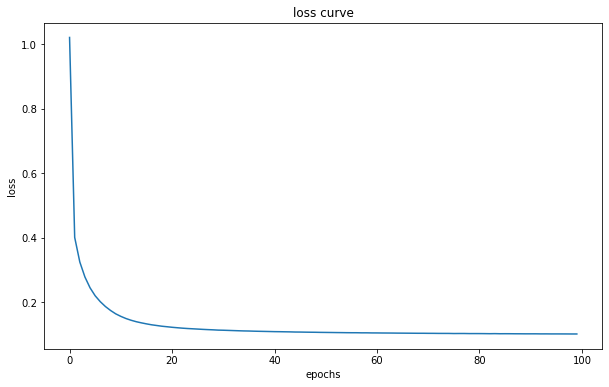

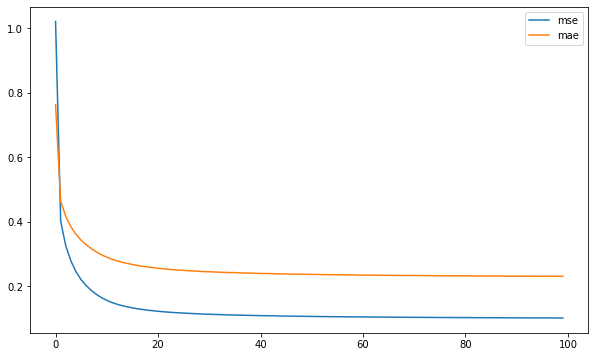

In [40]:
import matplotlib.pyplot as plt 

plt.title("loss curve")
plt.xlabel("epochs")
plt.ylabel("loss")
pd.DataFrame(history.history)["loss"].plot(figsize=(10,6)) 
pd.DataFrame(history.history)[["mse", "mae"]].plot(figsize=(10,6))
plt.show() 

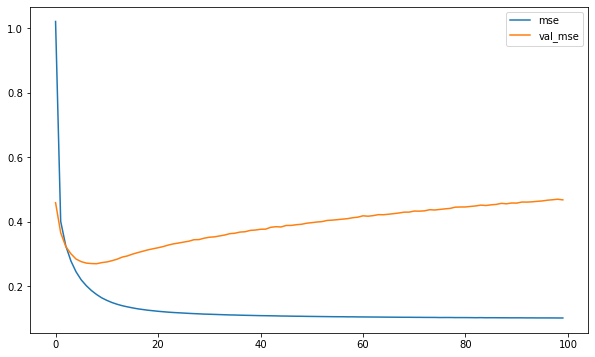

In [41]:
pd.DataFrame(history.history)[["mse", "val_mse"]].plot(figsize=(10,6))
plt.show() 

In [42]:
model.set_weights(initial_weights)

In [43]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=3)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
history = model.fit(
    [X_train.LHS_C, X_train.RHS_C], 
    y_train,
    validation_data=([X_test.LHS_C, X_test.RHS_C], y_test),
    epochs=100, 
    callbacks=[early_stopping]
)

Epoch 1/100
5959/5959 [==============================] - 13s 2ms/step - loss: 1.0400 - mae: 0.7703 - mse: 1.0400 - val_loss: 0.4706 - val_mae: 0.5013 - val_mse: 0.4706
Epoch 2/100
5959/5959 [==============================] - 13s 2ms/step - loss: 0.4114 - mae: 0.4691 - mse: 0.4114 - val_loss: 0.3763 - val_mae: 0.4502 - val_mse: 0.3763
Epoch 3/100
5959/5959 [==============================] - 14s 2ms/step - loss: 0.3285 - mae: 0.4182 - mse: 0.3285 - val_loss: 0.3242 - val_mae: 0.4193 - val_mse: 0.3242
Epoch 4/100
5959/5959 [==============================] - 14s 2ms/step - loss: 0.2738 - mae: 0.3819 - mse: 0.2738 - val_loss: 0.2945 - val_mae: 0.4018 - val_mse: 0.2945
Epoch 5/100
5959/5959 [==============================] - 16s 3ms/step - loss: 0.2403 - mae: 0.3579 - mse: 0.2403 - val_loss: 0.2818 - val_mae: 0.3954 - val_mse: 0.2818
Epoch 6/100
5959/5959 [==============================] - 14s 2ms/step - loss: 0.2177 - mae: 0.3408 - mse: 0.2177 - val_loss: 0.2742 - val_mae: 0.3916 - val_mse:

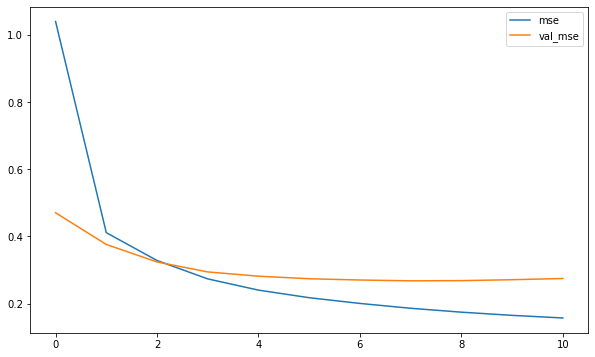

In [44]:
pd.DataFrame(history.history)[["mse", "val_mse"]].plot(figsize=(10,6))
plt.show() 

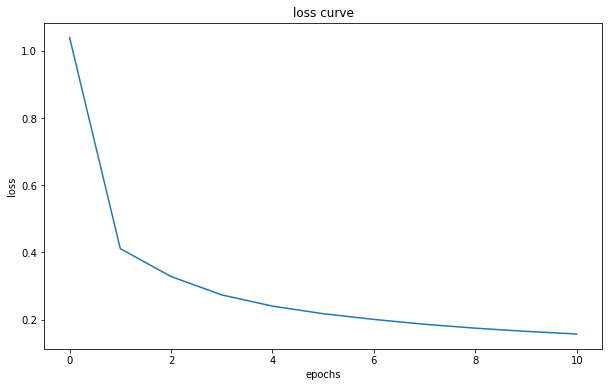

In [45]:
plt.title("loss curve")
plt.xlabel("epochs")
plt.ylabel("loss")
pd.DataFrame(history.history)["loss"].plot(figsize=(10,6)) 
plt.show() 

In [46]:
lhs_embddings = model.get_layer(name='lhs-embeddings').get_weights()[0]
lhs_embddings

array([[-0.11623395, -0.09986712, -0.11909172, ..., -0.10081229,
        -0.1337532 ,  0.1318173 ],
       [-0.3066547 , -0.21134132, -0.41803384, ..., -0.4607549 ,
        -0.23593378,  0.20037816],
       [-0.28429577,  0.27812958, -0.29721174, ..., -0.35217762,
         0.34429386,  0.33419627],
       ...,
       [ 0.43445095,  0.42501554, -0.14163914, ...,  0.47359365,
        -0.42596227, -0.34164253],
       [ 0.20680295,  0.20020875,  0.1009037 , ...,  0.16558404,
        -0.2338995 , -0.16779369],
       [-0.03541844,  0.04276851,  0.02352561, ...,  0.00205154,
         0.0498364 ,  0.04266817]], dtype=float32)

In [47]:
rhs_embddings = model.get_layer(name='rhs-embeddings').get_weights()[0]
rhs_embddings

array([[-0.30502406,  0.29119977, -0.26442772, ..., -0.33042777,
         0.285473  ,  0.3202859 ],
       [-0.28331167, -0.26091728, -0.4092876 , ..., -0.1730644 ,
        -0.39779127,  0.33520943],
       [ 0.08616025,  0.09679467, -0.12054111, ...,  0.05200026,
        -0.1064205 , -0.07502282],
       ...,
       [ 0.24271174,  0.2942544 , -0.3217186 , ...,  0.2707314 ,
        -0.34226972, -0.3000191 ],
       [ 0.14283338,  0.10537926, -0.22653131, ...,  0.17938589,
        -0.27235213, -0.15059714],
       [ 0.03513676, -0.04578748,  0.03363255, ..., -0.04576157,
         0.02327817,  0.01225855]], dtype=float32)

In [48]:
def recommend(option_in_category, number_of_options=5):
  options = lhs_embddings[option_in_category]@rhs_embddings.T
  mids = np.argpartition(options, -number_of_options)[-number_of_options:]
  
  return mids

In [49]:
sublist_by_2_concat.LHS.value_counts()[:20]

753600    1066
753376    1048
753350     779
753536     745
753509     718
751600     698
753609     693
753517     604
759397     592
751526     584
753572     572
760352     544
748802     541
746304     508
753314     502
753507     497
670176     493
749920     485
760353     482
764515     476
Name: LHS, dtype: int64

In [50]:
sublist_by_2_concat[sublist_by_2_concat.LHS == 759397].head()     # RHS = 721495, LHS = 751839

,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
1010,1.386294,"(759397, 753355)",2,759397,753355,3491,3049
1011,4.844187,"(759397, 753357)",2,759397,753357,3491,3051
1012,2.397895,"(759397, 755827)",2,759397,755827,3491,3386
1013,2.197225,"(759397, 753301)",2,759397,753301,3491,3017
1014,5.187386,"(759397, 753433)",2,759397,753433,3491,3088


In [51]:
id_list = recommend(
    3678,
    10
)

sublist_by_2_concat.query("RHS_C in @id_list").RHS.unique() 

array([751581, 753433, 789122, 764172, 764175, 764174, 753446, 645694,
       754180, 823710], dtype=int64)

In [52]:
id_list

array([3088, 3096, 3249, 3766, 4724,  412, 4797, 3763, 3765, 2851],
      dtype=int64)

### Model.2 : With 3's Combine 

In [53]:
dataset_combined_MF.head() 

,rating,bill,option_count,LHS,RHS
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328


In [54]:
dataset_combined_MF["LHS_C"] = dataset_combined_MF.LHS.astype('category').cat.codes.values
dataset_combined_MF["RHS_C"] = dataset_combined_MF.RHS.astype('category').cat.codes.values

dataset_combined_MF.head() 

,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494,0,4244
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574,1,3410
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358,2,2753
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574,3,3410
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328,4,2489


In [55]:
len(dataset_combined_MF["RHS_C"].unique()), len(dataset_combined_MF["LHS_C"].unique())

(4898, 111164)

In [56]:
n_rhs, n_lhs = len(dataset_combined_MF.RHS_C.unique()), len(dataset_combined_MF.LHS_C.unique())
n_latent_factors = 20
# input, embedding --> 
lhs_input = keras.layers.Input(shape=(1,), name="lhs-item") 
lhs_embedding = keras.layers.Embedding(n_lhs + 1, n_latent_factors, name="lhs-embeddings")(lhs_input) 
lhs_vec = keras.layers.Flatten(name="flatten-lhs")(lhs_embedding) 

rhs_input= keras.layers.Input(shape=(1,), name="rhs-item")
rhs_embedding = keras.layers.Embedding(n_rhs + 1, n_latent_factors, name="rhs-embeddings")(rhs_input) 
rhs_vec = keras.layers.Flatten(name="flatten-rhs")(rhs_embedding)

product = keras.layers.dot([lhs_vec, rhs_vec], axes=1, name="dot-product") 
model_2 = keras.Model([lhs_input, rhs_input], product) 

model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [57]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(dataset_combined_MF[["RHS_C", "LHS_C"]], dataset_combined_MF.rating, test_size=0.10) 
X_train_3[:5], y_train_3[:5]

(        RHS_C   LHS_C
 140139   3091   26251
 388939   4063   86421
 590233   1846  106964
 150201    341   15057
 279769   2784   65863,
 140139    0.693147
 388939    1.098612
 590233    1.098612
 150201    1.098612
 279769    0.693147
 Name: rating, dtype: object)

In [58]:
cp_callback = keras.callbacks.ModelCheckpoint(filepath="../checkpoints/model_2.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=6)
history = model_2.fit(
    [X_train_3.LHS_C, X_train_3.RHS_C], 
    np.array(y_train_3, dtype=float),
    validation_data=([X_test_3.LHS_C, X_test_3.RHS_C], np.array(y_test_3, dtype=float)),
    epochs=100, 
    callbacks=[early_stopping, cp_callback]
)

# Model 2: Apriori (apyori Module)

In [ ]:
associations = apriori(
    transactions,
    min_length = 2,
    max_length=4,
    min_support = 0.0001,
    min_confidence = 0.0001,
    min_lift = 0.0001,
)

associations = list(associations)
len(associations)

8374

In [ ]:
association = associations[100]
print(association)
print("support", association.support)
print(association.ordered_statistics)
print("right", association.ordered_statistics[0].items_add)
print("left", association.ordered_statistics[0].items_base)
print("confidence", association.ordered_statistics[0].confidence)
print("lift", association.ordered_statistics[0].lift)


RelationRecord(items=frozenset({635458}), support=0.0007728733714453959, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({635458}), confidence=0.0007728733714453959, lift=1.0)])
support 0.0007728733714453959
[OrderedStatistic(items_base=frozenset(), items_add=frozenset({635458}), confidence=0.0007728733714453959, lift=1.0)]
right frozenset({635458})
left frozenset()
confidence 0.0007728733714453959
lift 1.0


In [ ]:
rules = [] 
for association in associations:
    if len(association.ordered_statistics) > 1: 
        rules.append(association)

In [ ]:
len(rules)

5228

In [ ]:
rules 